# Restaurant Location Recommendations Through Data Analysis Of Venues Within New York Neighborhoods

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [23]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

## 1. Preparing the New York dataframe

The required data set containing the needed information on New York City has already been downloaded. We will now load the dataset and convert it to a data frame using the pandas library. 

In [32]:
#opening the json file containing the data set and containing it in the variable newyork_data
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [33]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

All the relevant data is stored within the features key which is a list of all the neighborhoods in New York. We define a variable that includes this data. 

In [34]:
neighborhoodData = newyork_data['features']

We go on to transfrom the data set into a dataframe using pandas. We will need the name of the borough, the neighbourhoods within and the geo-location of each area. 

In [35]:
# defining the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [36]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude


We see the dataframe has been created successfully and now it's time to populate it with data from the new york data set.

In [37]:
#looping through the neighborhoodData object to obtain the relevant data and populate the newly created dataframe
for data in neighborhoodData:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [38]:
#ensuring that the dataframe contains all the boroughs and neighbourhoods
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [12]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [227]:
neighborhoods.dtypes

Borough          object
Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

In [346]:
#using geopy to get the gelocation of the Bronx 
address = 'Bronx, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of The Bronx are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of The Bronx are 40.8466508, -73.8785937.


## 2. Preparing the New York venues dataframe using the Four Square API

In [39]:
CLIENT_ID = 'W3H4FHMKKTKSNPZNLVFXKE2HQORWZ1NOH0ASFNPPSCH353BA' # Foursquare ID
CLIENT_SECRET = 'IBB4EYDQXH1PZSCFNU5KQYDYO3QSXGX0JOGEYVSFWRZO1DVW' # Foursquare Secret
ACCESS_TOKEN = 'RURAHMIHUCDG21JRXN5ZUP2D2EP4MOQUPDBR3SHS3PGLR0W1' # FourSquare Access Token
VERSION = '20200501'
LIMIT = 11000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: W3H4FHMKKTKSNPZNLVFXKE2HQORWZ1NOH0ASFNPPSCH353BA
CLIENT_SECRET:IBB4EYDQXH1PZSCFNU5KQYDYO3QSXGX0JOGEYVSFWRZO1DVW


In [40]:
#getting a list of all the venues thar are in neighbourhoods around New York
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [42]:
#applying the above function to each neighbourhood in New York and storing this in a new dataframe : newyork_venues
newyork_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [44]:
print(newyork_venues.shape)
newyork_venues.head()

(10047, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [49]:
#determining the total number of unique venue categories 
print('There are {} uniques categories.'.format(len(newyork_venues['Venue Category'].unique())))

There are 426 uniques categories.


## 3. Clustering the neighborhoods

### 3. 1 Creating a one hot vector for the mean frequency of each category in each neighborhood 

In [171]:
# one hot encoding
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]

newyork_onehot.head()

,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,...,Volleyball Court,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
newyork_onehot.shape

(10047, 426)

In [99]:
# Group and average the frequency of unique category in each neighborhood
newyork_grouped = newyork_onehot.groupby('Neighborhood').mean().reset_index()
newyork_grouped

,Neighborhood,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,...,Volleyball Court,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Allerton,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
1,Annadale,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
2,Arden Heights,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
3,Arlington,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
4,Arrochar,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,Woodhaven,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
298,Woodlawn,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.038462,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
299,Woodrow,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
300,Woodside,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.038462,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0


In [51]:
newyork_grouped.shape

(302, 426)

### 3.2 Applying K Means Clustering to the engineered feature set

Now that I have my selection of features I need to find the best K and apply the K Means clustering algorithm on the feature set. 

#### Finding the best k using the elbow method

In [298]:
#looping through the clustering distortions to find the best k 
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(newyork_grouped.drop(columns={'Neighborhood'}, axis=1))
    distortions.append(kmeanModel.inertia_)




The elbow appears to be at the point when k is 8. We will set the number of clusters to 8 when applying K Means.

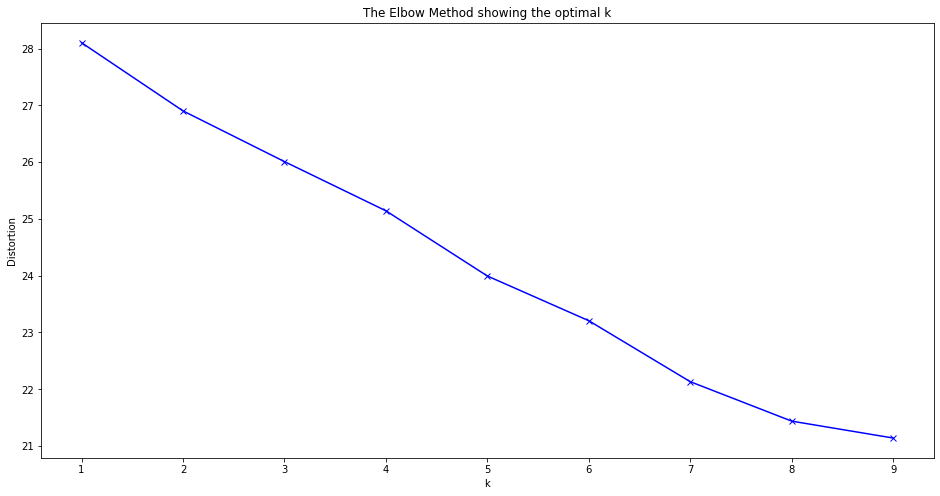

In [299]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The optimal k seems to be 8

In [305]:
# Set up k and run KMean
k = 8
km = KMeans(n_clusters=k, random_state=0).fit(newyork_grouped.drop(columns={'Neighborhood'}, axis=1))
kclusters = 8

# 4. Characterising the clusters 

### 4.1 Obtaining the most common venues

In [243]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [306]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(newyork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Bakery,Bus Station,Chinese Restaurant,Deli / Bodega,Spa,Supermarket,Martial Arts School,Fast Food Restaurant,Gas Station
1,Annadale,Pizza Place,Food,Pharmacy,Train Station,Diner,Restaurant,American Restaurant,Bakery,Cosmetics Shop,Food & Drink Shop
2,Arden Heights,Home Service,Pharmacy,Deli / Bodega,Coffee Shop,Pizza Place,Women's Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit
3,Arlington,Bus Stop,American Restaurant,Grocery Store,ATM,Intersection,Deli / Bodega,Coffee Shop,Farmers Market,Farm,Falafel Restaurant
4,Arrochar,Pizza Place,Deli / Bodega,Italian Restaurant,Bagel Shop,Bus Stop,Nail Salon,Outdoors & Recreation,Middle Eastern Restaurant,Sandwich Place,Liquor Store


### 4.1 Merging the New York Data with the Most Common Venue Data

In [307]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', km.labels_)

newyork_merged = neighborhoods

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
newyork_merged = newyork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

newyork_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,3,Pharmacy,Deli / Bodega,Laundromat,Sandwich Place,Dessert Shop,Food,Donut Shop,Ice Cream Shop,Caribbean Restaurant,Farmers Market
1,Bronx,Co-op City,40.874294,-73.829939,3,Restaurant,Bus Station,Fried Chicken Joint,Park,Baseball Field,Grocery Store,Bagel Shop,Pharmacy,Fast Food Restaurant,Pizza Place
2,Bronx,Eastchester,40.887556,-73.827806,2,Deli / Bodega,Caribbean Restaurant,Bus Station,Diner,Chinese Restaurant,Automotive Shop,Donut Shop,Bowling Alley,Business Service,Pizza Place
3,Bronx,Fieldston,40.895437,-73.905643,0,Bus Station,River,Plaza,Business Service,Women's Store,Field,Ethiopian Restaurant,Event Service,Event Space,Exhibit
4,Bronx,Riverdale,40.890834,-73.912585,7,Bus Station,Park,Bank,Medical Supply Store,Gym,Plaza,Baseball Field,Food Truck,Food & Drink Shop,Farm


In [295]:
newyork_merged.shape

(306, 15)

#### Graphing the dataframe 

In [487]:
cMain = newyork_merged['1st Most Common Venue'].value_counts().to_frame()

In [489]:
cMain.rename(columns = {'1st Most Common Venue':'Venue Count'}, inplace = True) 

In [491]:
cMain.head()

,Venue Count
Pizza Place,37
Italian Restaurant,24
Coffee Shop,19
Deli / Bodega,18
Chinese Restaurant,16


Text(0.5, 1.0, 'Distribution of venues in New York')

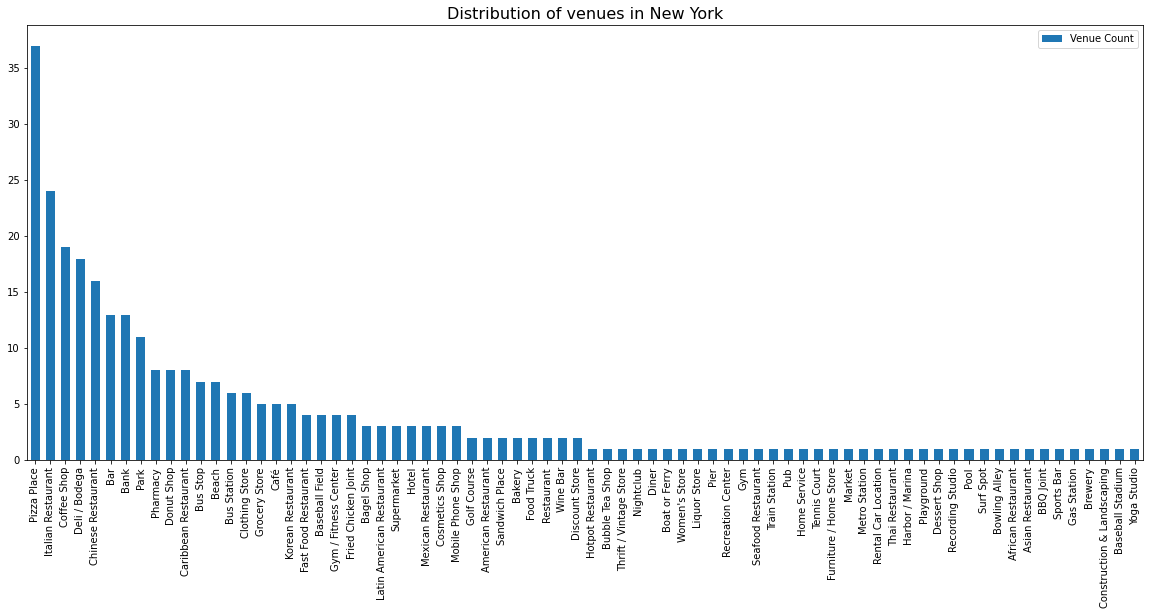

In [494]:
ax = cMain.plot(kind='bar',figsize=(20, 8), width= 0.6)
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set(facecolor = "white")
ax.spines['bottom'].set_color('black')

ax.set_title('Distribution of venues in New York', fontsize= 16)


In [308]:
print('Number of members in each cluster: ')
newyork_merged['Cluster Labels'].value_counts()

Number of members in each cluster: 


3    132
0    118
2     39
7     12
5      2
6      1
4      1
1      1
Name: Cluster Labels, dtype: int64

### Comments

From the graph above the most occuring venue in New York is pizza places with the least being yoga studios. 

Out of the 8 clusters , clusters two, five and seven have less than 3 neighborhoods respectively so they can be classified as outliers. We will ignore these clusters and analyze the rest,

In [567]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged['Latitude'], newyork_merged['Longitude'], newyork_merged['Neighborhood'], newyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [472]:
newclusterny = clusterny.drop(['Borough','Neighborhood','Latitude','Longitude','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue','6th Most Common Venue','7th Most Common Venue','8th Most Common Venue','9th Most Common Venue','10th Most Common Venue'], axis=1)

# 5. Cluster Analysis

### Cluster One 

In [315]:
cluster1 = newyork_merged.loc[newyork_merged['Cluster Labels'] == 0, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

In [285]:
cluster1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Fieldston,Bus Station,River,Plaza,Business Service,Women's Store,Field,Ethiopian Restaurant,Event Service,Event Space,Exhibit
9,Williamsbridge,Nightclub,Caribbean Restaurant,Bar,Soup Place,Food Stand,Farmers Market,Fountain,Event Service,Event Space,Exhibit
12,City Island,Thrift / Vintage Store,Seafood Restaurant,Café,Diner,Bar,Baseball Field,Boat or Ferry,Harbor / Marina,Smoke Shop,Park
28,Throgs Neck,Italian Restaurant,American Restaurant,Pizza Place,Coffee Shop,Asian Restaurant,Deli / Bodega,Sports Bar,Bar,Event Space,Exhibit
34,Belmont,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Bank,Donut Shop,Mexican Restaurant,Grocery Store,Dessert Shop,Food & Drink Shop
...,...,...,...,...,...,...,...,...,...,...,...
294,Malba,Tennis Court,Bus Line,Rest Area,Rock Club,Vegetarian / Vegan Restaurant,Women's Store,Farmers Market,Entertainment Service,Ethiopian Restaurant,Event Service
296,Madison,Bagel Shop,Pilates Studio,Pizza Place,Candy Store,Restaurant,Spa,Dessert Shop,Deli / Bodega,Italian Restaurant,Eye Doctor
301,Hudson Yards,Gym / Fitness Center,Hotel,Italian Restaurant,Café,American Restaurant,Dog Run,Park,Gym,Restaurant,Coffee Shop
302,Hammels,Beach,Fried Chicken Joint,Bus Station,Gym / Fitness Center,Fast Food Restaurant,Dog Run,Bus Stop,Diner,Shoe Store,Food Truck


In [316]:
cluster1.describe()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,118,118,118,118,118,118,118,118,118,118,118
unique,115,38,59,55,61,63,64,74,72,77,69
top,Bay Terrace,Italian Restaurant,Coffee Shop,Pizza Place,Cocktail Bar,American Restaurant,Italian Restaurant,Bar,Event Service,Event Space,Exhibit
freq,2,20,11,12,8,7,7,4,7,8,8


In [506]:
c = cluster1['1st Most Common Venue'].value_counts().to_frame()

In [507]:
c.rename(columns = {'1st Most Common Venue':'Venue Count'}, inplace = True) 

In [508]:
c.head()

,Venue Count
Italian Restaurant,20
Coffee Shop,19
Bar,12
Beach,6
Clothing Store,5


Text(0.5, 1.0, 'Distribution of venues in Cluster One')

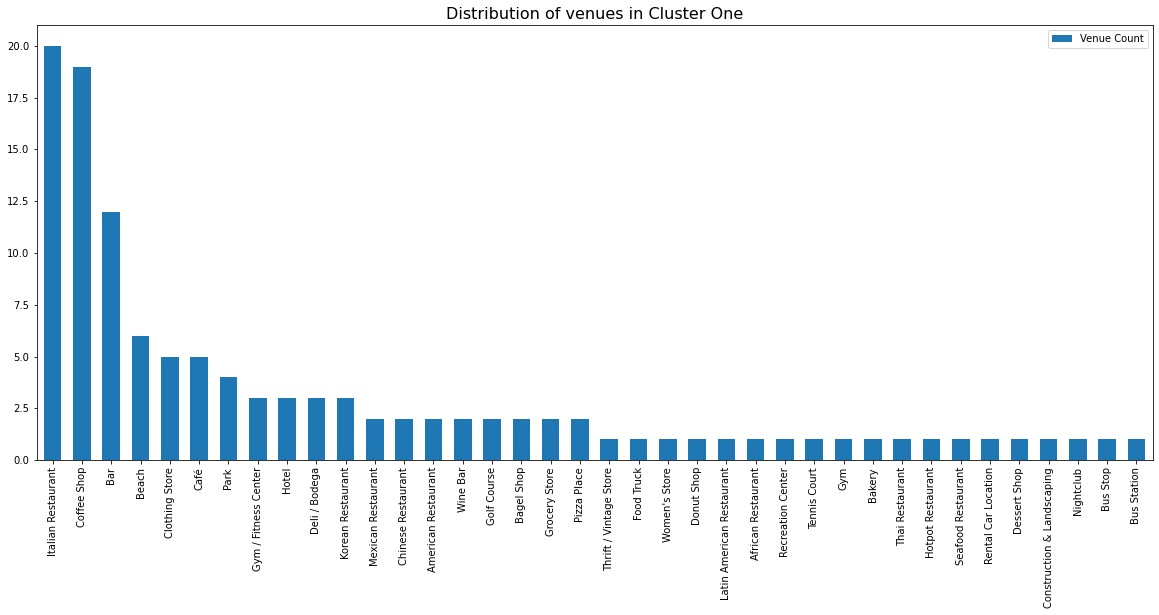

In [509]:
ax = c.plot(kind='bar',figsize=(20, 8), width= 0.6)
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set(facecolor = "white")
ax.spines['bottom'].set_color('black')

ax.set_title('Distribution of venues in Cluster One', fontsize= 16)

#### Comment 

The cluster is densely populated with over 100 neighborhoods. We can conclude that this is an eatery cluster with Italian restaurants and coffee shops being the most commonly occuring venues.it is most probably an area for the high income working class

### Cluster Three

In [496]:
cluster3 = newyork_merged.loc[newyork_merged['Cluster Labels'] == 2, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

In [498]:
cluster3.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Eastchester,Deli / Bodega,Caribbean Restaurant,Bus Station,Diner,Chinese Restaurant,Automotive Shop,Donut Shop,Bowling Alley,Business Service,Pizza Place
7,Woodlawn,Pub,Deli / Bodega,Pizza Place,Food & Drink Shop,Bar,Grocery Store,Park,Donut Shop,Trail,Train Station
15,Morris Heights,Deli / Bodega,Bank,Pizza Place,Pharmacy,Bus Station,Supermarket,Spanish Restaurant,Grocery Store,Exhibit,Fast Food Restaurant
32,Van Nest,Pizza Place,Deli / Bodega,Cosmetics Shop,Bus Stop,Shop & Service,Middle Eastern Restaurant,Coffee Shop,Donut Shop,Board Shop,Hookah Bar
41,Olinville,Caribbean Restaurant,Basketball Court,Deli / Bodega,Supermarket,Food,Chinese Restaurant,Laundromat,Women's Store,Fast Food Restaurant,Event Space


In [499]:
cluster3.describe()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,39,39,39,39,39,39,39,39,39,39,39
unique,39,17,22,25,28,34,30,32,27,29,27
top,Briarwood,Deli / Bodega,Deli / Bodega,Deli / Bodega,Bus Stop,Bus Station,Women's Store,Field,Event Space,Exhibit,Eye Doctor
freq,1,11,13,6,3,2,5,4,5,6,6


In [500]:
c3 = cluster3['1st Most Common Venue'].value_counts().to_frame()

In [501]:
c3.rename(columns = {'1st Most Common Venue':'Venue Count'}, inplace = True) 

Text(0.5, 1.0, 'Distribution of venues in Cluster Three')

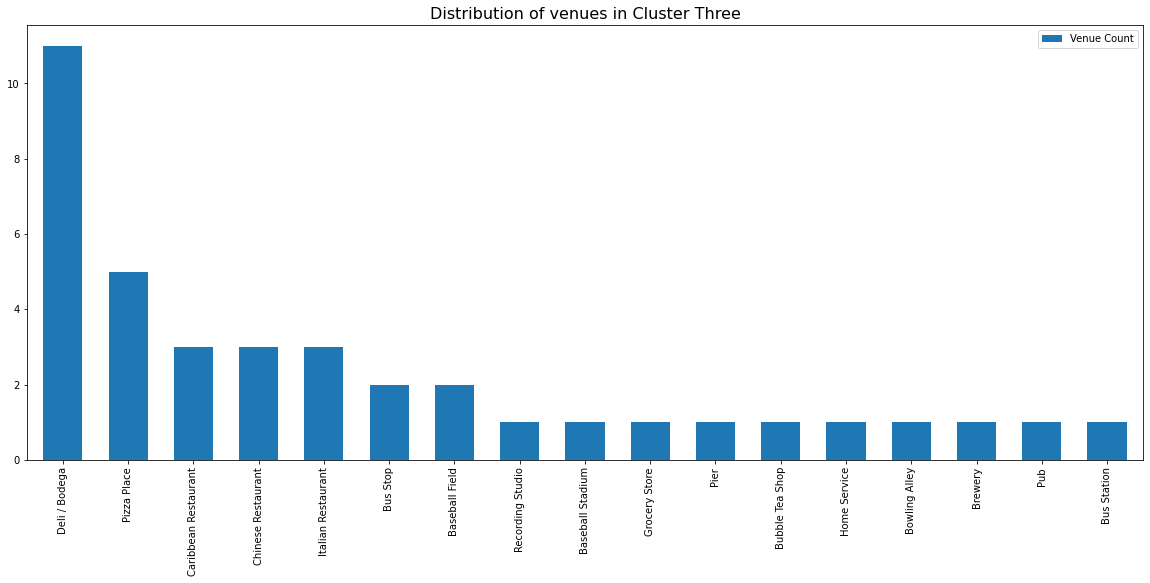

In [504]:
ax = c3.plot(kind='bar',figsize=(20, 8), width= 0.6)
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set(facecolor = "white")
ax.spines['bottom'].set_color('black')

ax.set_title('Distribution of venues in Cluster Three', fontsize= 16)

#### Comment 

The cluster is fairly populated with 39 neighborhoods. It appears to be a retail cluster with deli's/bodegas as the most commonly occuring venues. It can also be said to be an eatery cluster to some extent as most deli's serve food to customers as well. It is most probably an area for the lower income working class.

### Cluster Four

In [526]:
cluster4 = newyork_merged.loc[newyork_merged['Cluster Labels'] == 3, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

In [527]:
cluster4.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,Pharmacy,Deli / Bodega,Laundromat,Sandwich Place,Dessert Shop,Food,Donut Shop,Ice Cream Shop,Caribbean Restaurant,Farmers Market
1,Co-op City,Restaurant,Bus Station,Fried Chicken Joint,Park,Baseball Field,Grocery Store,Bagel Shop,Pharmacy,Fast Food Restaurant,Pizza Place
5,Kingsbridge,Pizza Place,Bar,Bakery,Latin American Restaurant,Sandwich Place,Mexican Restaurant,Supermarket,Café,Fried Chicken Joint,Liquor Store
6,Marble Hill,Discount Store,Coffee Shop,Gym,Sandwich Place,Yoga Studio,Department Store,Diner,Kids Store,Video Game Store,Pizza Place
8,Norwood,Pizza Place,Chinese Restaurant,Park,Bank,Pharmacy,Restaurant,Grocery Store,Mexican Restaurant,Spanish Restaurant,Liquor Store


In [528]:
cluster4.describe()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,132,132,132,132,132,132,132,132,132,132,132
unique,131,41,59,59,59,68,78,66,63,81,62
top,Sunnyside,Pizza Place,Grocery Store,Pizza Place,Sandwich Place,Pizza Place,Donut Shop,Bank,Bakery,Pizza Place,Pharmacy
freq,2,30,8,12,10,8,9,8,7,6,7


In [529]:
c4 = cluster4['1st Most Common Venue'].value_counts().to_frame()

In [530]:
c4.rename(columns = {'1st Most Common Venue':'Venue Count'}, inplace = True) 

Text(0.5, 1.0, 'Distribution of venues in Cluster Four')

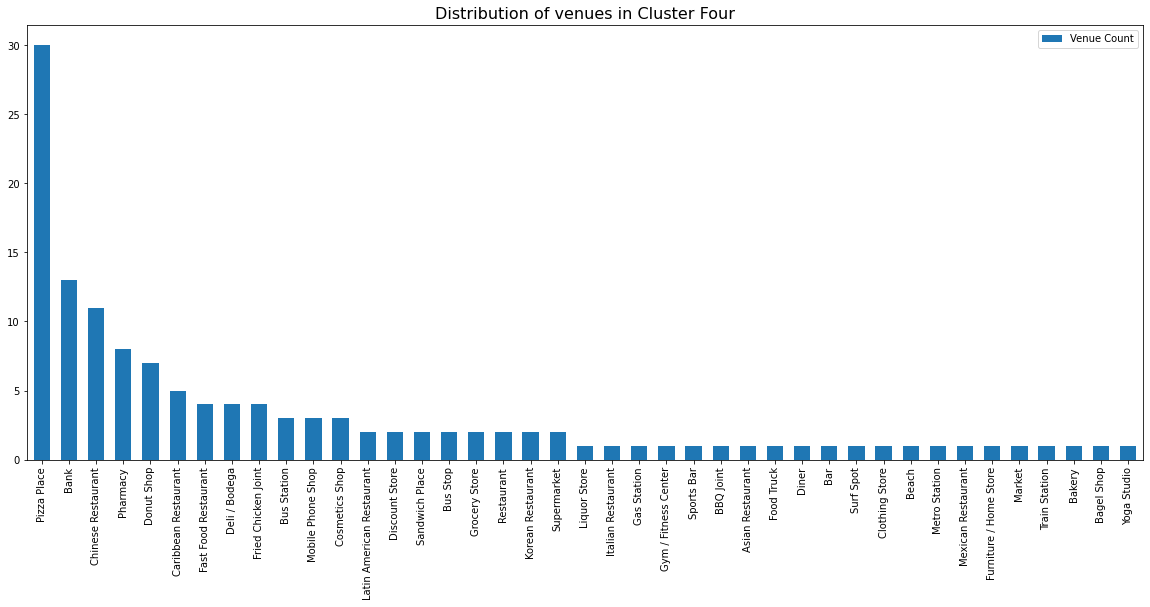

In [531]:
ax = c4.plot(kind='bar',figsize=(20, 8), width= 0.6)
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set(facecolor = "white")
ax.spines['bottom'].set_color('black')

ax.set_title('Distribution of venues in Cluster Four', fontsize= 16)

#### Comment 

The cluster is densely populated with over 100 neighborhoods. It seems to be an eatery cluster with pizza places being the most commonly occuring venue. Across the other commonly occuring venues there are also numerous food joints.It is most probably an area for students 

### Cluster Eight

In [519]:
cluster8 = newyork_merged.loc[newyork_merged['Cluster Labels'] == 7, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

In [520]:
cluster8.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Riverdale,Bus Station,Park,Bank,Medical Supply Store,Gym,Plaza,Baseball Field,Food Truck,Food & Drink Shop,Farm
27,Clason Point,Park,Convenience Store,Grocery Store,Boat or Ferry,Bus Stop,Pool,South American Restaurant,Flower Shop,Farmers Market,Event Service
35,Spuyten Duyvil,Park,Bank,Intersection,Thai Restaurant,Grocery Store,Tennis Stadium,Scenic Lookout,Tennis Court,Pharmacy,Factory
91,Bergen Beach,Harbor / Marina,Baseball Field,Park,Athletics & Sports,Playground,Fast Food Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit
148,South Ozone Park,Park,Bar,Deli / Bodega,Donut Shop,Food Truck,Fast Food Restaurant,Sandwich Place,Hotel,Factory,Falafel Restaurant


In [521]:
cluster8.describe()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,12,12,12,12,12,12,12,12,12,12,12
unique,12,5,8,10,11,12,11,11,11,11,9
top,Somerville,Park,Park,Deli / Bodega,Boat or Ferry,Bus Stop,Fast Food Restaurant,Discount Store,Event Service,Event Space,Farm
freq,1,7,4,3,2,1,2,2,2,2,2


In [522]:
c8 = cluster8['1st Most Common Venue'].value_counts().to_frame()

In [523]:
c8.rename(columns = {'1st Most Common Venue':'Venue Count'}, inplace = True) 

Text(0.5, 1.0, 'Distribution of venues in Cluster Eight')

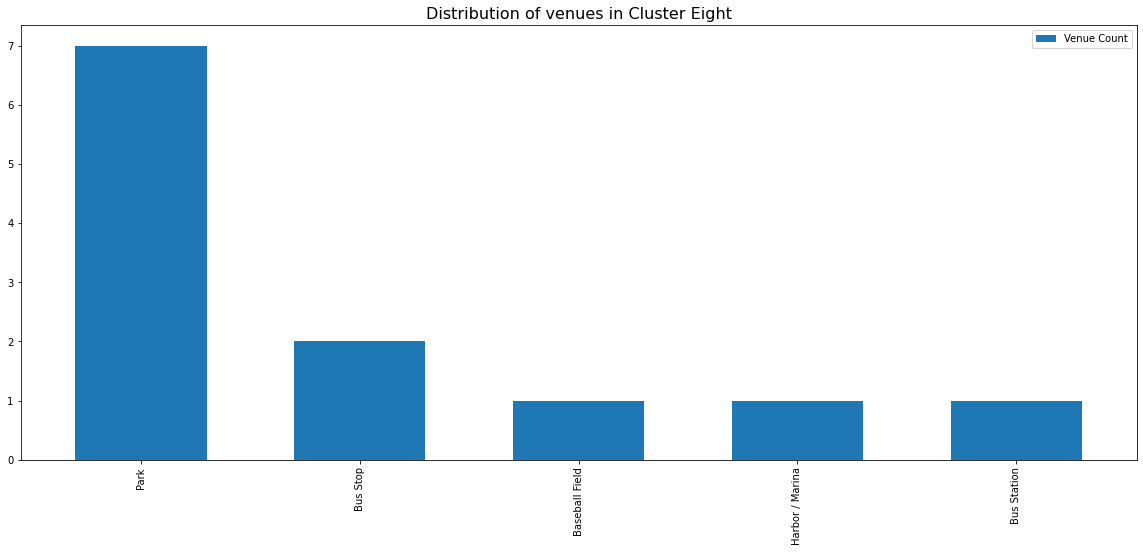

In [525]:
ax = c8.plot(kind='bar',figsize=(20, 8), width= 0.6)
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set(facecolor = "white")
ax.spines['bottom'].set_color('black')

ax.set_title('Distribution of venues in Cluster Eight', fontsize= 16)

#### Comment 

The cluster is sparsely populated with only 12 neighborhoods. It seems to be an activity cluster for those who like outdoor leisure activities with parks being the most common venue.

# 6. Locating Ideal Locations to Open a Restaurant

Now that we have characterized and described our respective clusters it is time to narrow down on the dataset and determine what would be the best location to open a restaurant within New York . 

### Step 1 : Filter the final merged dataset to include only neighborhoods with restaurants as their least (10th) most common venue

#### Filtering least common venue

In [532]:
#create a new variable to hold the filtered data set
newyork2 = newyork_merged[newyork_merged['10th Most Common Venue'].str.contains("estaurant")]
newyork2.head()


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Bronx,Morris Heights,40.847898,-73.919672,2,Deli / Bodega,Bank,Pizza Place,Pharmacy,Bus Station,Supermarket,Spanish Restaurant,Grocery Store,Exhibit,Fast Food Restaurant
24,Bronx,Hunts Point,40.809730,-73.883315,3,Bank,Juice Bar,Shipping Store,Grocery Store,BBQ Joint,Gourmet Shop,Farmers Market,Café,Pizza Place,Seafood Restaurant
30,Bronx,Parkchester,40.837938,-73.856003,3,Supermarket,Pizza Place,Kids Store,Women's Store,Shoe Store,Mattress Store,Mexican Restaurant,Mobile Phone Shop,Spanish Restaurant,Caribbean Restaurant
38,Bronx,Schuylerville,40.826580,-73.826203,3,Bank,Diner,Pizza Place,Pharmacy,Mexican Restaurant,Fast Food Restaurant,Hookah Bar,Sandwich Place,Donut Shop,American Restaurant
39,Bronx,Edgewater Park,40.821986,-73.813885,0,Italian Restaurant,Chinese Restaurant,Coffee Shop,Pizza Place,Juice Bar,Park,Bar,Liquor Store,Donut Shop,Asian Restaurant


In [533]:
print('Number of members in each cluster: ')
newyork2['Cluster Labels'].value_counts()

Number of members in each cluster: 


0    30
3    24
2     6
7     1
5     1
Name: Cluster Labels, dtype: int64

In [534]:
newyork2.shape

(62, 15)

After this we need to filter the dataframe again to remove venues with Italian Restaurants as their top occuring venue

#### Filter most common venue

In [535]:
ny2new = newyork2.loc[newyork2['1st Most Common Venue'] != 'Italian Restaurant']

In [536]:
ny2new.head()
ny2new.shape

(57, 15)

In [337]:
print('Number of members in each cluster: ')
ny2new['Cluster Labels'].value_counts()

Number of members in each cluster: 


0    25
3    24
2     6
7     1
5     1
Name: Cluster Labels, dtype: int64

#### Filtering by geographic location 

The final filtering step would be to locate only neighborhoods that are closed to the CBD. We will get the coordinates of Manhattan as our central location and only pick venues that are close to it using the latitude and longitude values.

In [540]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


We want venues whose latitude is as close to 40.8 and whose longitude is close to 73.96

In [571]:
ny3 = ny2new.loc[(ny2new['Longitude'] > -74) & (ny2new['Longitude'] < -72) & (ny2new['Latitude'] > 40) & (ny2new['Latitude'] < 40.8)]

In [572]:
ny3.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
58,Brooklyn,Windsor Terrace,40.656946,-73.980073,0,Deli / Bodega,Plaza,Grocery Store,Park,Arts & Crafts Store,Food Truck,Butcher,Café,Bookstore,Sushi Restaurant
59,Brooklyn,Prospect Heights,40.676822,-73.964859,0,Bar,Mexican Restaurant,Wine Shop,Cocktail Bar,Coffee Shop,Thai Restaurant,Bakery,Beer Bar,Wine Bar,Restaurant
65,Brooklyn,Cobble Hill,40.687920,-73.998561,0,Pizza Place,Playground,Coffee Shop,Cocktail Bar,Deli / Bodega,Italian Restaurant,Bar,Bakery,Dive Bar,Chinese Restaurant
76,Brooklyn,Mill Island,40.606336,-73.908186,5,Pool,Women's Store,Filipino Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant
84,Brooklyn,Clinton Hill,40.693229,-73.967843,0,Pizza Place,Italian Restaurant,Thai Restaurant,Wine Shop,Chinese Restaurant,Mexican Restaurant,Restaurant,Yoga Studio,Japanese Restaurant,Indian Restaurant


In [573]:
ny3.shape


(36, 15)

In [558]:
print('Number of members in each cluster: ')
ny3['Cluster Labels'].value_counts()

Number of members in each cluster: 


0    18
3    13
2     3
7     1
5     1
Name: Cluster Labels, dtype: int64

Cluster two and four do not feature in this set . 

### Step 2 : Obtain a list of all the potential neighborhoods to setup a restaurant in 

In [537]:
#Generate a list of all unique neighborhoods in the filtered dataset 
ny3['Neighborhood'].unique().tolist()

['Woodhaven',
 'South Ozone Park',
 'St. Albans',
 'Rosedale',
 'Far Rockaway',
 'Neponsit',
 'Brookville']

### Step 3 : Visualize these locations on a map 

In [559]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny3['Latitude'], ny3['Longitude'], ny3['Neighborhood'], ny3['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters